# **Potato Disease Classification**

# Importing dependencies and setting constants

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Data import into tensorflow dataset object

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

 88% 33.0M/37.4M [00:00<00:00, 84.4MB/s]
100% 37.4M/37.4M [00:00<00:00, 81.9MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-disease-leaf-datasetpld.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3251 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [37]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 1 1 2 2 2 2 0 2 0 2 2 2 1 1 1 2 1 1 2 0 2 1 1 2 0 1 0 0]


### Images from dataset visualizisation

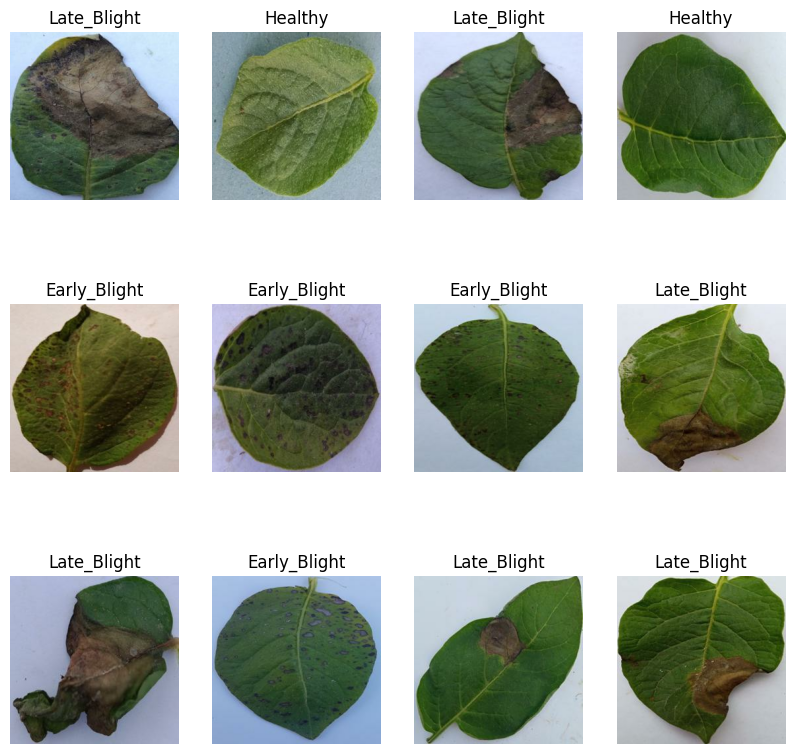

In [36]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Spliting Dataset

In [38]:
len(dataset)

102

In [41]:
train_size = 0.8
len(dataset)*train_size

81.60000000000001

In [42]:
train_ds = dataset.take(54)
len(train_ds)

54

In [43]:
test_ds = dataset.skip(54)
len(test_ds)

48

In [44]:
val_size=0.1
len(dataset)*val_size

10.200000000000001

In [45]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [46]:
test_ds = test_ds.skip(6)
len(test_ds)

42

In [47]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [48]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [49]:
len(train_ds)

81

In [50]:
len(val_ds)

10

In [51]:
len(test_ds)

11

In [52]:
#Cache, Shuffle, and Prefetch the Dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building

###Layer for Resizing and Normalization and Data Augmentation

In [53]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [54]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [55]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Model Compilation

In [57]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [58]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
81/81 [==============================] - 31s 320ms/step - loss: 1.0663 - accuracy: 0.3928 - val_loss: 1.0037 - val_accuracy: 0.4437
Epoch 2/50
81/81 [==============================] - 22s 273ms/step - loss: 0.8934 - accuracy: 0.5878 - val_loss: 0.7625 - val_accuracy: 0.7156
Epoch 3/50
81/81 [==============================] - 22s 273ms/step - loss: 0.6578 - accuracy: 0.7410 - val_loss: 0.8392 - val_accuracy: 0.6875
Epoch 4/50
81/81 [==============================] - 22s 273ms/step - loss: 0.5941 - accuracy: 0.7724 - val_loss: 0.6386 - val_accuracy: 0.7500
Epoch 5/50
81/81 [==============================] - 22s 272ms/step - loss: 0.3566 - accuracy: 0.8763 - val_loss: 0.2432 - val_accuracy: 0.9219
Epoch 6/50
81/81 [==============================] - 22s 269ms/step - loss: 0.3307 - accuracy: 0.8813 - val_loss: 0.3537 - val_accuracy: 0.8656
Epoch 7/50
81/81 [==============================] - 22s 274ms/step - loss: 0.2584 - accuracy: 0.9050 - val_loss: 0.1941 - val_accuracy: 0.9312

In [59]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 3s 27ms/step - loss: 0.0209 - accuracy: 0.9915


In [60]:
scores

#[loss,accuracy]

[0.02093816176056862, 0.9914772510528564]

### Plotting the Accuracy and Loss Curves

In [61]:
history

In [62]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 81}

In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [64]:
type(history.history['loss'])

list

In [65]:
len(history.history['loss'])

50

In [66]:
history.history['loss'][:5]

[1.0662685632705688,
 0.8934341669082642,
 0.6578329801559448,
 0.5941261649131775,
 0.356613427400589]

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

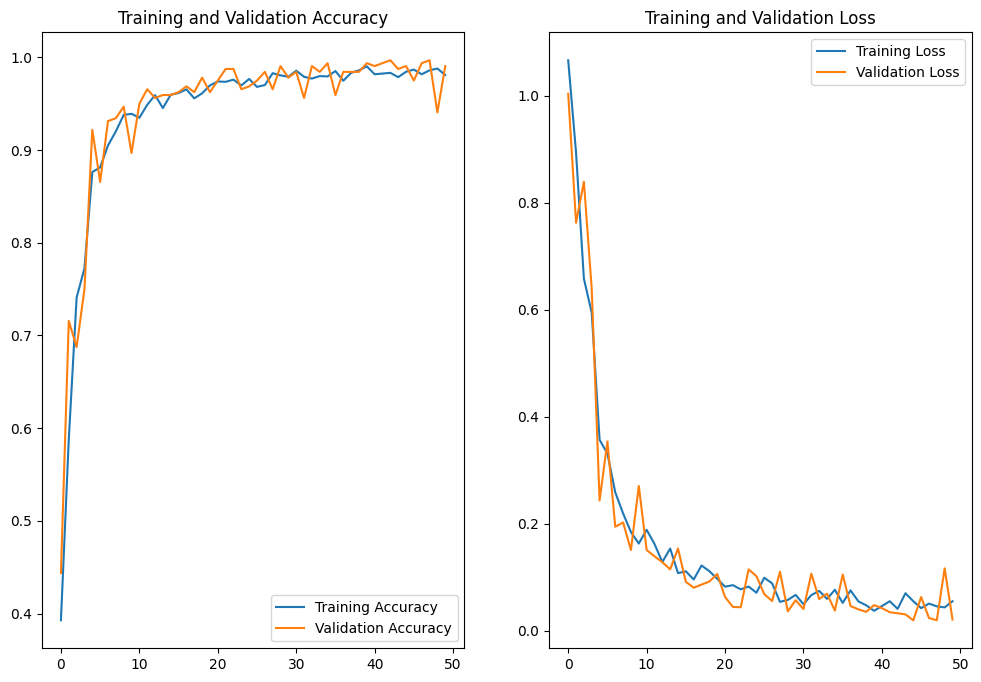

In [75]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Run prediction on a sample image

first image to predict
actual label: Late_Blight
1/1 [==============================] - 0s 149ms/step
predicted label: Late_Blight


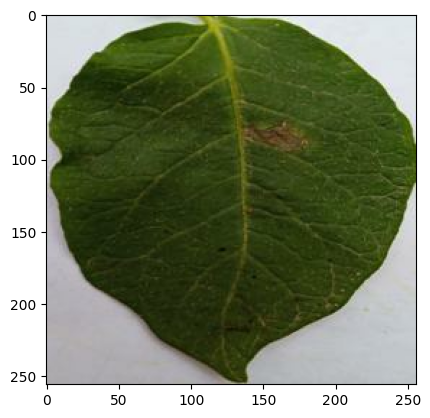

In [76]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### inference

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


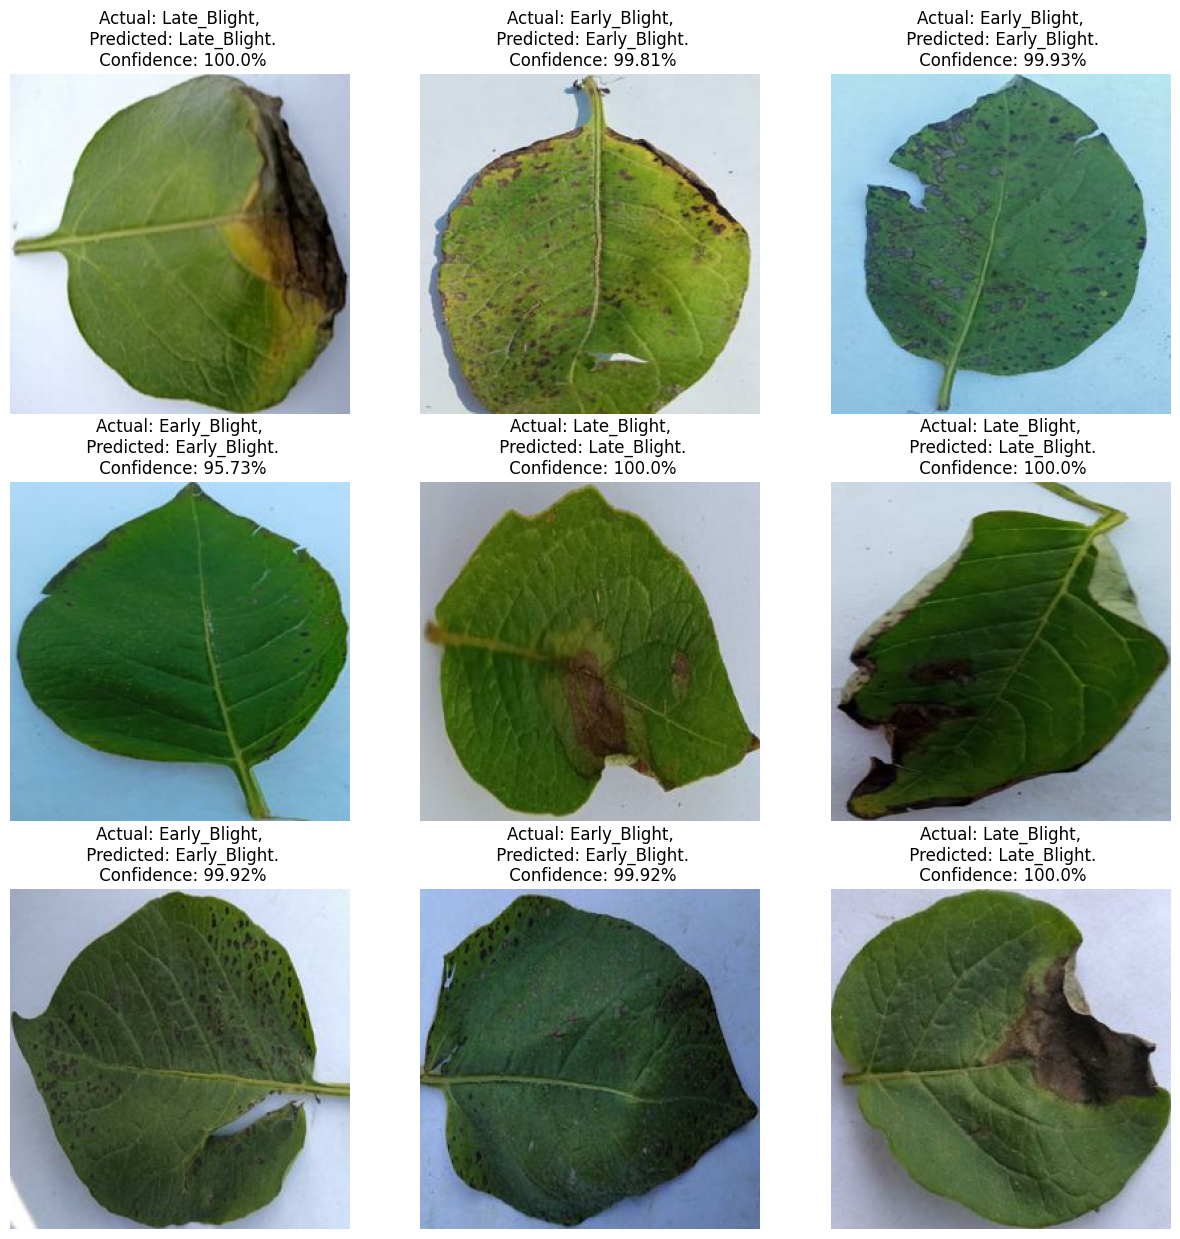

In [78]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [79]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [Errno 2] No such file or directory: '../models'

In [ ]:
model.save("../potatoes.h5")